## 
# Taller 5: Encoders y decoders
### Parte 1:
### Por: Samuel Mesa
### Fecha; Mayo 2 de 2021

**Objetivo**: Cree un autoencoder para el conjunto de datos Fashion MNIST, usando una red convolucional. Los datos puede obtenerlos directamente en keras como se hizo el conjunto MNIST de dígitos.





Carga el conjunto de datos MNIST. 
Se trata de un conjunto de datos de 60.000 imágenes 
en escala de grises de 28x28 de los 10 dígitos, 
junto con un conjunto de prueba de 10.000 imágenes. 

**Returns**

Tuple of NumPy arrays: (x_train, y_train), (x_test, y_test).

**x_train**: uint8 NumPy array of grayscale image data with shapes (60000, 28, 28), 
containing the training data. Pixel values range from 0 to 255.

**y_train**: uint8 NumPy array of digit labels (integers in range 0-9) 
with shape (60000,) for the training data.

**x_test**: uint8 NumPy array of grayscale image data with shapes (10000, 28, 28), 
containing the test data. Pixel values range from 0 to 255.

**y_test**: uint8 NumPy array of digit labels (integers in range 0-9) 
with shape (10000,) for the test data.

## Importa módulos


In [17]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt 
import os  
from tensorflow.keras.layers import Dense, Input, Conv2D, Conv2DTranspose, Flatten, Reshape, Activation 
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint 
from tensorflow.keras.datasets import cifar100 
from tensorflow.keras.utils import plot_model

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError


## Leer datos


In [2]:
mnist_fashion = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = mnist_fashion.load_data()

print("Forma de los datos de entrenamiento: ", train_images.shape)
print("Forma de los datos de test:",test_images.shape)

Forma de los datos de entrenamiento:  (60000, 28, 28)
Forma de los datos de test: (10000, 28, 28)


## Visualización de algunos datos

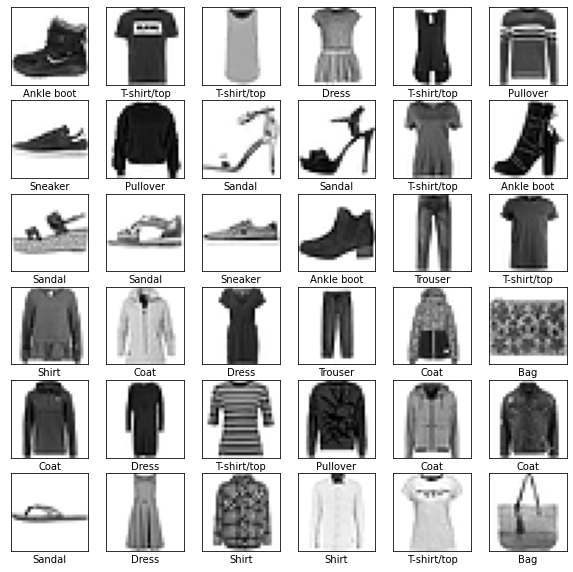

In [3]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat','Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.figure(figsize=(10,10))
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

## Normaliza los datos

In [4]:
train_images = train_images.astype('float32') / 255.
test_images = test_images.astype('float32') / 255.

## Configuración - Parametros de la red

In [6]:
input_shape = (28*28,) # 784
intermediate_dim_1 = 128
intermediate_dim_2 = 64
intermediate_dim_3 = 32
intermediate_dim_4 = 16
latent_dim = 3

## Encoder


In [7]:
# Define encoder model
inputs = Input(shape=input_shape,name='encoder_input')
x = Activation('relu')(inputs)
x = Dense(intermediate_dim_1, name='hidden_layer_1_e')(x)
x = Activation('relu')(x)
x = Dense(intermediate_dim_2, name='hidden_layer_2_e')(x)
x = Activation('relu')(x)
x = Dense(intermediate_dim_3, name='hidden_layer_3_e')(x)
x = Activation('relu')(x)
x = Dense(intermediate_dim_4, name='hidden_layer_4_e')(x)
x = Activation('relu')(x)
outputs = Dense(latent_dim, name='latent_space')(x)
#outputs = LayerNormalization(axis=1)(x)

encoder = Model(inputs=inputs, outputs=outputs, name='dense_encoder')


## Summary ENCODER


Model: "dense_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 784)]             0         
_________________________________________________________________
activation (Activation)      (None, 784)               0         
_________________________________________________________________
hidden_layer_1_e (Dense)     (None, 128)               100480    
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0         
_________________________________________________________________
hidden_layer_2_e (Dense)     (None, 64)                8256      
_________________________________________________________________
activation_2 (Activation)    (None, 64)                0         
_________________________________________________________________
hidden_layer_3_e (Dense)     (None, 32)              

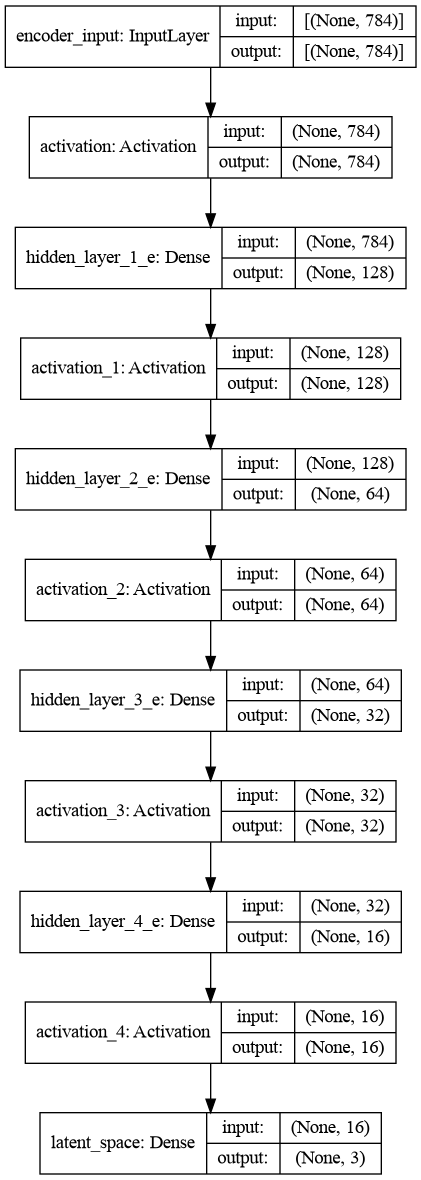

In [8]:
encoder.summary()
plot_model(encoder, to_file='./encoder_dense_fashion_minist.png',show_shapes=True)

## Decoder

In [9]:
# Define decoder model
latent_input = Input(shape = (latent_dim,), name='decoder_input')
x = Activation('relu')(latent_input)
x = Dense(intermediate_dim_4 , name='hidden_layer_de_4_d')(latent_input)
x = Activation('relu')(x)
x = Dense(intermediate_dim_3 , name='hidden_layer_de_3_d')(x)
x = Activation('relu')(x)
x = Dense(intermediate_dim_2 , name='hidden_layer_de_2_d')(x)
x = Activation('relu')(x)
x = Dense(intermediate_dim_1 , name='hidden_layer_de_1_d')(x)
x = Activation('relu')(x)
x = Dense(input_shape[0], name='original_space')(x)
x = Activation('sigmoid')(x)

decoder = Model (inputs=latent_input, outputs=x, name='decoder')

## Summary DECODER


Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 3)]               0         
_________________________________________________________________
hidden_layer_de_4_d (Dense)  (None, 16)                64        
_________________________________________________________________
activation_6 (Activation)    (None, 16)                0         
_________________________________________________________________
hidden_layer_de_3_d (Dense)  (None, 32)                544       
_________________________________________________________________
activation_7 (Activation)    (None, 32)                0         
_________________________________________________________________
hidden_layer_de_2_d (Dense)  (None, 64)                2112      
_________________________________________________________________
activation_8 (Activation)    (None, 64)                0   

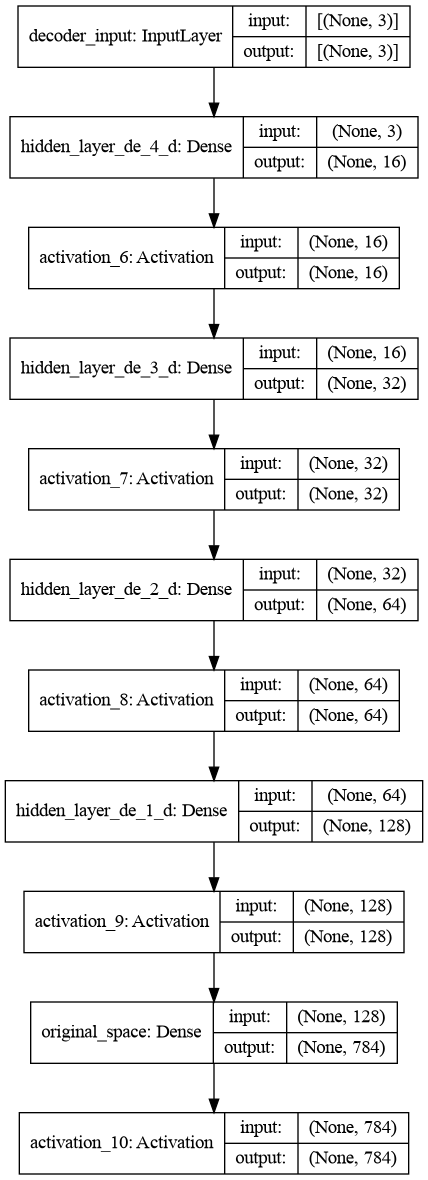

In [10]:
decoder.summary()
plot_model(decoder, to_file='./decoder_dense_fashion_minist.png',show_shapes=True)


## Autoencoder 


In [11]:
# Autoencoder Model
autoencoder = Model(inputs=inputs, 
                    outputs=decoder(encoder(inputs)),
                    name='autoencoder_mnist_fashion_model')

## Summary AUTOENCODER

Model: "autoencoder_mnist_fashion_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 784)]             0         
_________________________________________________________________
dense_encoder (Functional)   (None, 3)                 111395    
_________________________________________________________________
decoder (Functional)         (None, 784)               112176    
Total params: 223,571
Trainable params: 223,571
Non-trainable params: 0
_________________________________________________________________


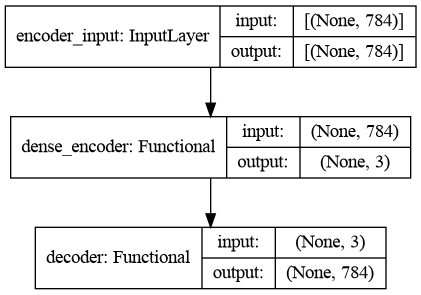

In [12]:
autoencoder.summary()
plot_model(autoencoder, to_file='./autoenautoencoder_mnist_fashion_model.png',show_shapes=True)

## Callbacks
Crea una clase derivada de tf.keras.callbacks.Callback
Se usa para pasar funciones de control al algoritmo de estimación.
Aquí la usaremos para que el entrenamiento pare cuando se alcance 
un determinado accuracy (Presiciòn) con los datos de entrenamiento.

In [13]:
class MNIST_Callback(tf.keras.callbacks.Callback):
    
    # método dentro de la clase myCallback, heredada de la clase Callback de keras
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.99):
            print("\nSe alcanzó un 99.9% de precisión en el entrenamiento! Cancelando Entrenamiento...")
            self.model.stop_training = True

# crea una instancia de clase
accu_callback = MNIST_Callback()

## Compila

In [14]:
optimizer = Adam(learning_rate=1e-3)
loss_fn = MeanSquaredError()
autoencoder.compile(optimizer= optimizer, loss = loss_fn)

## Entrenamiento


In [15]:
train_images = train_images.reshape(60000, 784).astype("float32")
test_images = test_images.reshape(10000, 784).astype("float32")

epochs = 200
batch_size = 64
history = autoencoder.fit(train_images, train_images, epochs = epochs, batch_size=batch_size, validation_split=0.1)


] - 5s 6ms/step - loss: 0.0231 - val_loss: 0.0234
Epoch 7/200
844/844 [==============================] - 5s 6ms/step - loss: 0.0228 - val_loss: 0.0231
Epoch 8/200
844/844 [==============================] - 5s 6ms/step - loss: 0.0228 - val_loss: 0.0228
Epoch 9/200
844/844 [==============================] - 5s 6ms/step - loss: 0.0231 - val_loss: 0.0229
Epoch 10/200
844/844 [==============================] - 5s 6ms/step - loss: 0.0225 - val_loss: 0.0222
Epoch 11/200
844/844 [==============================] - 5s 6ms/step - loss: 0.0220 - val_loss: 0.0220
Epoch 12/200
844/844 [==============================] - 5s 7ms/step - loss: 0.0216 - val_loss: 0.0220
Epoch 13/200
844/844 [==============================] - 10s 12ms/step - loss: 0.0216 - val_loss: 0.0219
Epoch 14/200
844/844 [==============================] - 9s 10ms/step - loss: 0.0214 - val_loss: 0.0216
Epoch 15/200
844/844 [==============================] - 8s 10ms/step - loss: 0.0213 - val_loss: 0.0213
Epoch 16/200
844/844 [=========

## Visualiza las perdias Loss y Val_Loss

In [18]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch 
hist.tail()

,loss,val_loss,epoch
195,0.018740,0.019230,195
196,0.018687,0.019445,196
197,0.018720,0.019437,197
198,0.018742,0.019524,198
199,0.018711,0.019406,199


## Perdida y graficas

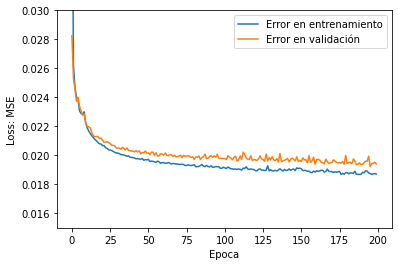

In [19]:
plt.figure()
plt.xlabel('Epoca')
plt.ylabel('Loss: MSE')
plt.plot(hist['epoch'], hist['loss'],
           label='Error en entrenamiento')
plt.plot(hist['epoch'], hist['val_loss'],
           label='Error en validación')
plt.ylim([0.015,0.03])
plt.legend()
plt.show()



## Evaluación del autoencoder

In [20]:
autoencoder.evaluate(test_images,test_images) 
autoencoder.evaluate(train_images,train_images) 

1875/1875 [==============================] - 10s 5ms/step - loss: 0.0187


0.01873849518597126

## Visualizacion de algunos elementos 



## Predicciones 

In [23]:
def display(array1, array2, n):
    """
    Displays ten random images from each one of the supplied arrays.
    """
    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(10, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

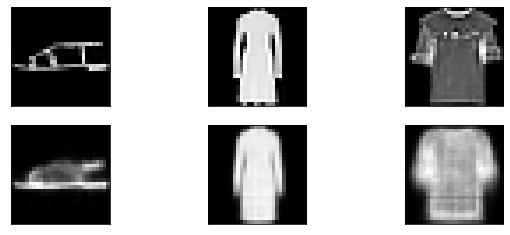

In [172]:
num = 3 # Numero de elementos
predictions = autoencoder.predict(test_images)
display(test_images, predictions, num) 